In this project we analyse textual data from Glassdoor to understand how employees rate their firms and how ratings can be predicted from the different types of comments left by employees. The dataset contains several types of ratings from 1 to 5 on different topics such as work-life balance, career opportunities and so on. For each review there is a headline, a pros and a cons rubric, as well as the date of the review, the firm rated, the title of the reviewer and her current situation.

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from termcolor import colored
from sklearn.impute import SimpleImputer

import os


In [6]:
pip install text.blob

ERROR: Could not find a version that satisfies the requirement text.blob (from versions: none)
ERROR: No matching distribution found for text.blob
Note: you may need to restart the kernel to use updated packages.


Here we load the reviews and focus on text data and the final firm's rating.

In [7]:
# Load Data
data    = pd.read_csv('Senti.csv', sep=',', encoding='latin-1')
Notkeep = [d for d in data.columns if d not in ['overall_rating','headline','pros','cons','firm','date_review']]
data    = data.drop(columns=Notkeep)
data['date_review'] = pd.to_datetime(data['date_review'])

In [8]:
data.head()

,firm,date_review,overall_rating,headline,pros,cons
0,Accenture,2008-06-11,3,big profits - poor people management,the name and access the C level,too much politics and not enough concentration...
1,Accenture,2008-06-12,3,A good employer but not without challenges - o...,"Great network, collaborative, bright people, c...",lacklustre senior management spending insuffic...
2,Accenture,2008-06-19,4,the grass is actually quite green on this side...,"Diversity of work, general calibre of people,","increasing level of bureaucracy, complexity of..."
3,Accenture,2008-06-20,4,"A good company to work for, but dont expect a ...","driven and focused company, which does give op...",Don't expect a life or significant amounts of ...
4,Accenture,2008-06-26,3,An okay place to be!,The variety of work and clients can be inspiri...,The long hours and the promotion (laddering) p...


In [9]:
comfort=[]
for ele in data['overall_rating']:
    if float(ele)>3:
        comfort.append("Satisfied")
    elif float(ele)>1:
        comfort.append('Neutral')
    else:
        comfort.append('Dissatisfied')
data['Comfort']=comfort
data

,firm,date_review,overall_rating,headline,pros,cons,Comfort
0,Accenture,2008-06-11,3,big profits - poor people management,the name and access the C level,too much politics and not enough concentration...,Neutral
1,Accenture,2008-06-12,3,A good employer but not without challenges - o...,"Great network, collaborative, bright people, c...",lacklustre senior management spending insuffic...,Neutral
2,Accenture,2008-06-19,4,the grass is actually quite green on this side...,"Diversity of work, general calibre of people,","increasing level of bureaucracy, complexity of...",Satisfied
3,Accenture,2008-06-20,4,"A good company to work for, but dont expect a ...","driven and focused company, which does give op...",Don't expect a life or significant amounts of ...,Satisfied
4,Accenture,2008-06-26,3,An okay place to be!,The variety of work and clients can be inspiri...,The long hours and the promotion (laddering) p...,Neutral
...,...,...,...,...,...,...,...
1236,Morgan-Stanley,2008-06-11,4,fine,I am feeling prestige with M/s,industry stability is not guaranted,Satisfied
1237,Morgan-Stanley,2008-06-11,5,Best investment banking employer on Wall Street,"In short, great pay, great colleagues, great i...","Unpredictable hours, long hours, sometimes sub...",Satisfied
1238,Morgan-Stanley,2008-06-11,3,Don't take it too seriously. You'll never get...,"It is a very prestigious place to work, but th...","It is an ok place to work, but the lifestyle i...",Neutral
1239,Morgan-Stanley,2008-06-11,5,MS is a place for bright people that want to w...,"At Morgan Stanley, I am surrounded by the brig...",The largest downside of working at any investm...,Satisfied


In [10]:
train1=data['Comfort'].value_counts()
train1

Satisfied       681
Neutral         487
Dissatisfied     73
Name: Comfort, dtype: int64

Missing entries are scarce in the dataset: 

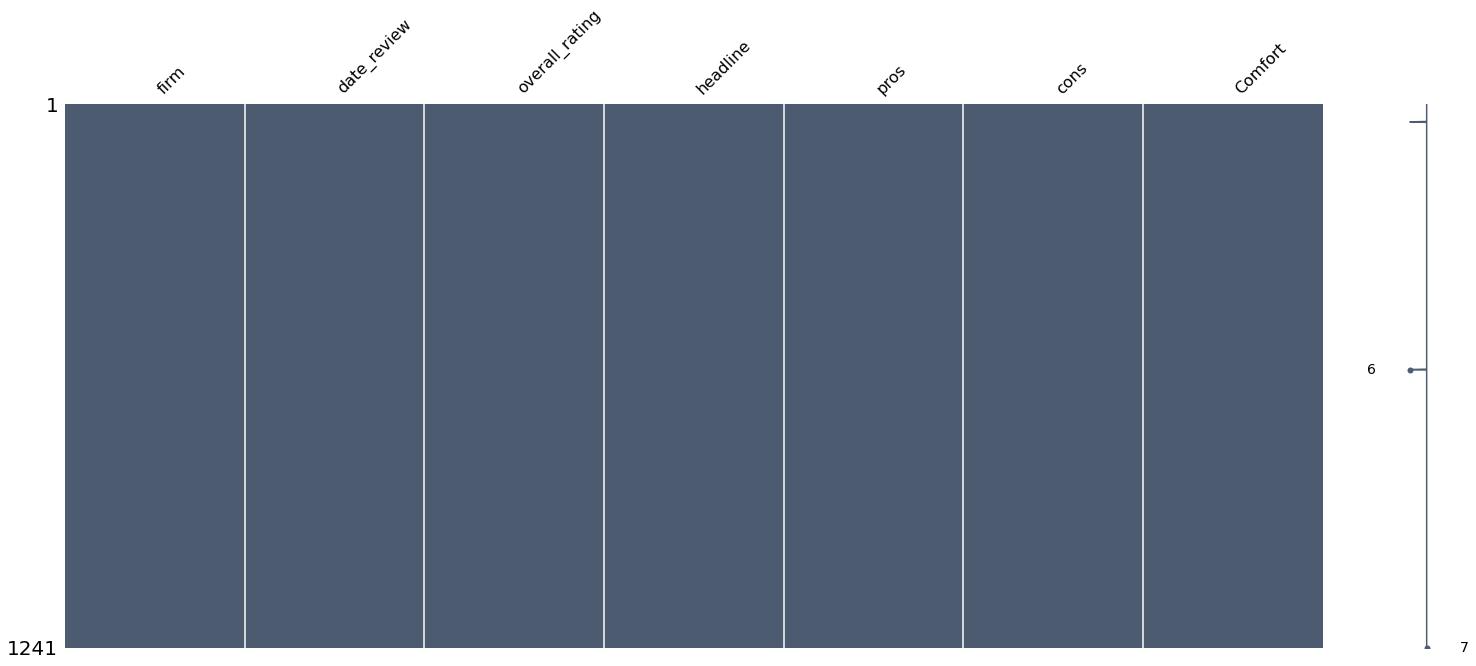

In [11]:
# Check Nans
msno.matrix(data,color=(0.3,0.36,0.44));

In [12]:
data.isna().sum()

firm              0
date_review       0
overall_rating    0
headline          2
pros              0
cons              0
Comfort           0
dtype: int64

Here we do a bit of cleaning. Some of the entries are duplicated, we remove those and replace NaN with their mean values for floats, or an NA value for strings.

In [13]:

# Get column names for each types 
types_str = data.select_dtypes(include='object').columns
types_int = data.select_dtypes(include=[int,float]).columns

# Fill missing according to types
data[types_str] = data[types_str].fillna('NA')
data[types_int] = SimpleImputer(strategy='mean').fit_transform(data[types_int])

# Drop Duplicates
duplicate = data[['headline','pros','cons']].duplicated()
data      = data.loc[duplicate==False]
data = data.reset_index()
print('Drop Duplicated:',duplicate.sum())

Drop Duplicated: 61


In [14]:
data['year'] = pd.DatetimeIndex(data['date_review']).year

n_samples, n_columns = data.shape # extract dimensions of the Data
n_data = pd.DataFrame(data.columns)[0] # the columns of our dataset

print('The data contains: {} samples of dimension {}'.format(n_samples, n_columns))

The data contains: 1180 samples of dimension 9


We can see a few entries from the dataset, namely the coments and ratings for several firms.

In [15]:
# Show an example for each grade
for i in range(1,6):
    tmp = data.query('overall_rating==@i').sample(1)
    print(colored(tmp.firm.values[0].upper(),'blue'),'\n'+tmp.headline.values[0],'\nHeadline: ',tmp.headline.values[0],colored('\nPros:','green'),tmp.pros.values[0],colored('\nCons:','red'),tmp.cons.values[0],'\nRating:',colored(tmp.overall_rating.values[0],'red'),'\n')

ACCENTURE 
Good company, good benefits but no work life balance. 
Headline:  Good company, good benefits but no work life balance. 
Pros: Good salary for the work you have to do - however its like they say you have to earn your money and they make you earn your money.  From Analysts to Senior Managers there are lots of perks available, the salary is very good compared to other companies.  Diversety is very well promoted and everyone from various backgrounds are considered equally. 
Cons: Long hours for consultant's, especially on lots of short term projects.  Be ready to stay away from family and home.  Its hard to get managers to agree to local projects, and sometimes even if you are the best choice for a project closer to home others may be selected at ramdon. 
Rating: 1.0 

BARCLAYS 
Boring job, good pay. 
Headline:  Boring job, good pay. 
Pros: I joined not so long ago, and from my perspective the goods sides so far were: a very decent grad program, good sign on bonus and base sala

Some non-semantic features can be informative of the ratings. For instance the number of words in headline, pros and cons seems to be a good indicator of the rating. Longer comments seem to signal a better grade. This seems reasonable since more dedicated reviewers will probably take more time to acknowledge good employment experience. We illustrate this point in the next graph:

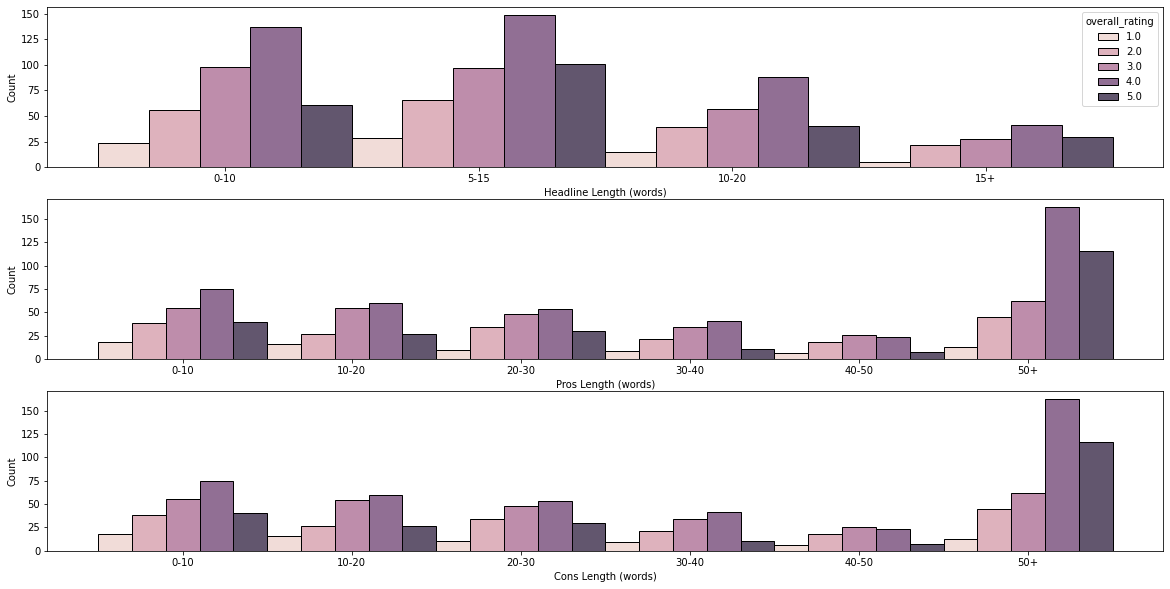

In [16]:
# Word Size Distribution depending on length of headlines, pros and cons
# The length of pros and cons is an important factor to detect polarity in opinions
data['head_len'] = data['headline'].apply(lambda x:len(nltk.word_tokenize(x)))
data['pros_len'] = data['pros'].apply(lambda x:len(nltk.word_tokenize(x)))
data['cons_len'] = data['pros'].apply(lambda x:len(nltk.word_tokenize(x)))

bins_h = list(range(0,20,5))+[1000]
bins   = list(range(0,60,10))+[1000]
data['head_len'] = pd.cut(data['head_len'], bins = bins_h, labels=[str(i)+'-'+str(i+10) for i in bins_h[:-2]]+[str(bins_h[-2])+'+'])
data['pros_len'] = pd.cut(data['pros_len'], bins = bins, labels=[str(i)+'-'+str(i+10) for i in bins[:-2]]+[str(bins[-2])+'+'])
data['cons_len'] = pd.cut(data['cons_len'], bins = bins, labels=[str(i)+'-'+str(i+10) for i in bins[:-2]]+[str(bins[-2])+'+'])

f,ax = plt.subplots(3,1,figsize=(20,10))
ax[0] = sns.histplot(data=data,x='head_len',hue='overall_rating',multiple="dodge",ax=ax[0])
ax[0].set_xlabel('Headline Length (words)')
ax[1] = sns.histplot(data=data,x='pros_len',hue='overall_rating',multiple="dodge",ax=ax[1], legend=False)
ax[1].set_xlabel('Pros Length (words)')
ax[2] = sns.histplot(data=data,x='cons_len',hue='overall_rating',multiple="dodge",ax=ax[2], legend=False)
ax[2].set_xlabel('Cons Length (words)')
plt.show()

Ratings are unevenly distributed across the sample.

<AxesSubplot:>

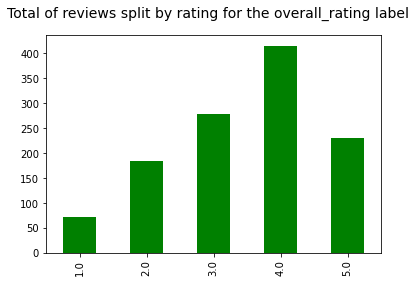

In [17]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
plt.suptitle("Total of reviews split by rating for the overall_rating label", fontsize=14)
data['overall_rating'].value_counts().sort_index(ascending=True).plot.bar(color="green")

We can see that the number of review is also very heterogeneous across firms.

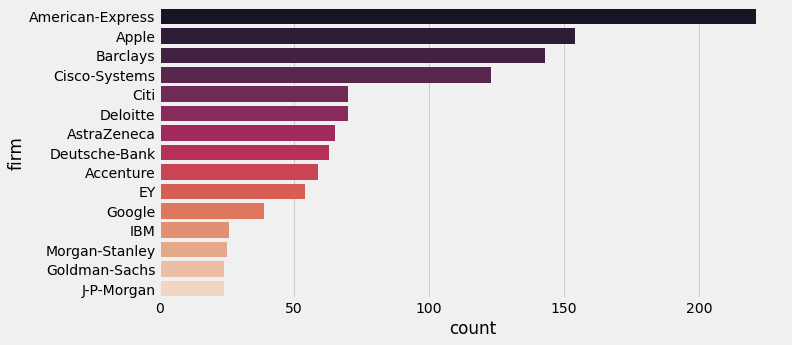

In [18]:
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (10 , 5))
sns.countplot(y = 'firm' , data = data , palette = 'rocket' , 
              order = data['firm'].value_counts().index[:15])
plt.show()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180 entries, 0 to 1179
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           1180 non-null   int64         
 1   firm            1180 non-null   object        
 2   date_review     1180 non-null   datetime64[ns]
 3   overall_rating  1180 non-null   float64       
 4   headline        1180 non-null   object        
 5   pros            1180 non-null   object        
 6   cons            1180 non-null   object        
 7   Comfort         1180 non-null   object        
 8   year            1180 non-null   int64         
 9   head_len        1180 non-null   category      
 10  pros_len        1180 non-null   category      
 11  cons_len        1180 non-null   category      
dtypes: category(3), datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 87.2+ KB


# Sentimental Analysis

In [20]:
from wordcloud import WordCloud

def wc(df,bgcolor,title):
    plt.figure(figsize = (50,50))
    wc = WordCloud(background_color = bgcolor, max_words = 2000, random_state=42, max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')
    return wc

In [21]:
df = pd.read_csv('Senti.csv')

Sentimental Polarity

In [22]:
polarity=[] # list which will contain the polarity of the comments
subjectivity=[] # list which will contain the subjectivity of the comments
for i in data['pros'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)

In [23]:
polarity = []
subjectivity = []
for i in data['pros'].values:
    analysis = TextBlob(i)
    polarity.append(analysis.sentiment.polarity)
    subjectivity.append(analysis.sentiment.subjectivity)

Sentiment Polarity and Subjectivity

In [24]:
data['polarity']=polarity
data['subjectivity']=subjectivity

In [25]:
data

,index,firm,date_review,overall_rating,headline,pros,cons,Comfort,year,head_len,pros_len,cons_len,polarity,subjectivity
0,0,Accenture,2008-06-11,3.0,big profits - poor people management,the name and access the C level,too much politics and not enough concentration...,Neutral,2008,5-15,0-10,0-10,0.000000,0.000000
1,1,Accenture,2008-06-12,3.0,A good employer but not without challenges - o...,"Great network, collaborative, bright people, c...",lacklustre senior management spending insuffic...,Neutral,2008,15+,20-30,20-30,0.391667,0.570833
2,2,Accenture,2008-06-19,4.0,the grass is actually quite green on this side...,"Diversity of work, general calibre of people,","increasing level of bureaucracy, complexity of...",Satisfied,2008,10-20,0-10,0-10,0.050000,0.500000
3,3,Accenture,2008-06-20,4.0,"A good company to work for, but dont expect a ...","driven and focused company, which does give op...",Don't expect a life or significant amounts of ...,Satisfied,2008,10-20,30-40,30-40,0.125000,0.291667
4,4,Accenture,2008-06-26,3.0,An okay place to be!,The variety of work and clients can be inspiri...,The long hours and the promotion (laddering) p...,Neutral,2008,5-15,20-30,20-30,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,1216,Morgan-Stanley,2008-06-11,3.0,"Need to be dedicated, but great potential here...","Good money, great place be if you are very car...","Work-life balance is hopeless, this is no diff...",Neutral,2008,15+,40-50,40-50,0.554762,0.590476
1176,1217,Morgan-Stanley,2008-06-12,4.0,Solid opportunities for the right individuals.,Morgan Stanley has still maintained a solid re...,Lack of technology resources for the support u...,Satisfied,2008,5-15,50+,50+,0.097889,0.272444
1177,1218,Morgan-Stanley,2008-06-12,2.0,Morgan Stanley Advisors say Firm must put Clie...,"Excellent reputation. The company is a ""house...",Rewards obscene for those at the very top of t...,Neutral,2008,10-20,10-20,10-20,1.000000,1.000000
1178,1219,Morgan-Stanley,2008-06-12,1.0,Go get a job at goldman instead.,"Decent benefits, white shoe reputation","Poor pay, low bonuses, red tape, 'too many chi...",Dissatisfied,2008,5-15,0-10,0-10,0.083333,0.333333


Displaying Polarity and Subjectivity of the headline and pros reviews

In [27]:
data[['firm','headline','pros','polarity','subjectivity']].head(10)

,firm,headline,pros,polarity,subjectivity
0,Accenture,big profits - poor people management,the name and access the C level,0.000000,0.000000
1,Accenture,A good employer but not without challenges - o...,"Great network, collaborative, bright people, c...",0.391667,0.570833
2,Accenture,the grass is actually quite green on this side...,"Diversity of work, general calibre of people,",0.050000,0.500000
3,Accenture,"A good company to work for, but dont expect a ...","driven and focused company, which does give op...",0.125000,0.291667
4,Accenture,An okay place to be!,The variety of work and clients can be inspiri...,0.500000,1.000000
5,Accenture,A great place to learn and grow... just be sur...,The people you work with;\r\nThe clients you w...,0.000000,0.000000
6,Accenture,Better than most other places to work,Working with talented people on big complicate...,0.066667,0.666667
7,Accenture,A place to spend a few years but not a long te...,Good for CV. Some of the people were great to...,0.650000,0.737500
8,Accenture,Great company if you work hard and don't have ...,"There is s huge variety of work available, and...",0.172513,0.638492
9,Accenture,Great place if you are ambitious and like work...,Accenture is a great place to learn about deli...,0.219625,0.479004


Positive reviews

In [30]:
data[['firm','headline','pros','polarity','subjectivity']][data.polarity>0].head(10)

,firm,headline,pros,polarity,subjectivity
1,Accenture,A good employer but not without challenges - o...,"Great network, collaborative, bright people, c...",0.391667,0.570833
2,Accenture,the grass is actually quite green on this side...,"Diversity of work, general calibre of people,",0.050000,0.500000
3,Accenture,"A good company to work for, but dont expect a ...","driven and focused company, which does give op...",0.125000,0.291667
4,Accenture,An okay place to be!,The variety of work and clients can be inspiri...,0.500000,1.000000
6,Accenture,Better than most other places to work,Working with talented people on big complicate...,0.066667,0.666667
7,Accenture,A place to spend a few years but not a long te...,Good for CV. Some of the people were great to...,0.650000,0.737500
8,Accenture,Great company if you work hard and don't have ...,"There is s huge variety of work available, and...",0.172513,0.638492
9,Accenture,Great place if you are ambitious and like work...,Accenture is a great place to learn about deli...,0.219625,0.479004
10,Accenture,Good place to begin your career in consulting,"Good place to start after university, if you a...",0.194859,0.547944
11,Accenture,Accenture - outstanding opportunities if you h...,"To Accenture employees ""the firm"" is both empl...",0.217459,0.534691


Negative Reviews

In [31]:
data[['firm','headline','pros','polarity','subjectivity']][data.polarity<0].head(10)

,firm,headline,pros,polarity,subjectivity
12,Accenture,"Good opportunities, but the workforce system s...",If you join the Consulting workforce in the UK...,-0.133333,0.233333
27,Accenture,"Tough at the middle, never mind the top!","Variety of work and top-class colleagues, who ...",-0.062500,0.237500
129,American-Express,Good work culture but pay sucks,Work life balance in some groups. - Although e...,-0.042857,0.414286
160,American-Express,AMEX is a great place to work for IT and techn...,"Flexible work arrangements, generous paid time...",-0.007341,0.407937
194,American-Express,Passive Aggressive Culture and it's all about ...,"Work Life balance is what they preach here, bu...",-0.061667,0.351667
210,American-Express,aexp employee,A stable company in these tough times. Opportu...,-0.388889,0.833333
326,Apple,Apple is amazing to work for!,I feel that I am treated like if not better th...,-0.002083,0.475000
331,Apple,Apple is not a bad place to work.,With Apple the computer world is at your finge...,-0.068571,0.632381
368,Apple,Apple Rocks as a place to work,"Products, culture and other things",-0.125000,0.375000
392,Apple,"If you want to make a difference in tech, ther...","You get a chance to innovate, making a differe...",-0.059848,0.597727


Highly Positive Reviews

In [32]:
data[['firm','headline','pros','polarity','subjectivity']][data.polarity>0.8].head(10)

,firm,headline,pros,polarity,subjectivity
74,American-Express,Overall amex is a good place to have a career,Work / Life balance is very good except in Fin...,0.9100,0.7800
180,American-Express,Senior Leaders at American Express demonstrat...,work life balance is the best,1.0000,0.3000
218,American-Express,Think Twice,work/life balance is the best thing,1.0000,0.3000
221,American-Express,Downside for working for a company for a long ...,Benifits--I beleive the benifits are very good.,0.9100,0.7800
468,AstraZeneca,AstraZeneca,The benefits and salary are the best part of t...,1.0000,0.3000
557,Barclays,Lack of Supervisor Communication,Benefits were probably the best part about wor...,1.0000,0.3000
718,Cisco-Systems,Great company to work for,Opportunity to work on the latest and the grea...,0.8750,0.6250
737,Cisco-Systems,Senior Software Engineer,"Very good compensation package, empowerment ov...",0.9100,0.7800
750,Cisco-Systems,cisco work life balance,cisco has good work life balance. very good co...,0.8050,0.6900
756,Cisco-Systems,good brand with no human touch,"great brand name, great support for crisis mom...",0.8275,0.7575


Highly Negative Reviews

In [33]:
data[['firm','headline','cons','polarity','subjectivity']][data.polarity<-0.25].head(10)

,firm,headline,cons,polarity,subjectivity
210,American-Express,aexp employee,Very regimented. Sometimes difficult to arran...,-0.388889,0.833333
463,AstraZeneca,IT Project Manager,"There is little teamwork, everyone is concerne...",-0.300000,0.450000
767,Citi,"CitiCorp, Fading Giant","too clannish, not as professional as other glo...",-0.800000,0.900000
772,Citi,A nice place to work but,"Very little leadership and career opportunies,...",-0.357143,0.578571
866,Deloitte,Deloitte Sucks,1. Very cutthroat\r\n2. No support structure\r...,-0.447222,0.487222


<AxesSubplot:>

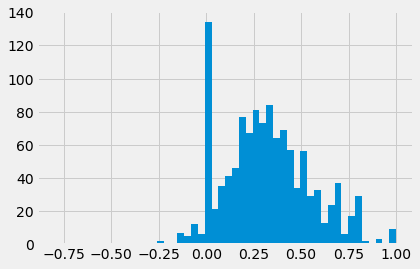

In [34]:
data.polarity.hist(bins=50)

<AxesSubplot:>

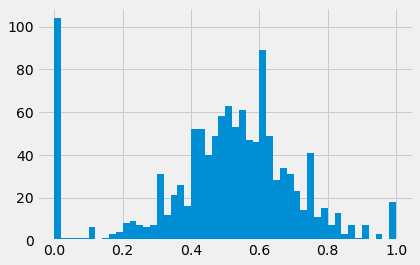

In [35]:
data.subjectivity.hist(bins=50)

In [36]:
data['polarity'][data.polarity==0]= 0
data['polarity'][data.polarity > 0]= 1
data['polarity'][data.polarity < 0]= -1

<ipython-input-36-c4e6596a10cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['polarity'][data.polarity==0]= 0
<ipython-input-36-c4e6596a10cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['polarity'][data.polarity > 0]= 1
<ipython-input-36-c4e6596a10cb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['polarity'][data.polarity < 0]= -1


 1.0    1020
 0.0     119
-1.0      41
Name: polarity, dtype: int64

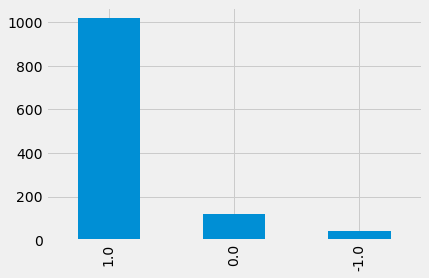

In [37]:
data.polarity.value_counts().plot.bar()
data.polarity.value_counts()

In [39]:
data = data
polarity=[] # list which will contain the polarity of the reviews
subjectivity=[] # list which will contain the subjectivity of the reviews
for i in data['cons'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)

In [40]:
data['polarity']=polarity
data['subjectivity']=subjectivity

In [41]:
data[['headline','pros','polarity','subjectivity']][data.polarity>0].head(10)

,headline,pros,polarity,subjectivity
0,big profits - poor people management,the name and access the C level,0.100000,0.350000
1,A good employer but not without challenges - o...,"Great network, collaborative, bright people, c...",0.253571,0.442857
3,"A good company to work for, but dont expect a ...","driven and focused company, which does give op...",0.102841,0.532386
8,Great company if you work hard and don't have ...,"There is s huge variety of work available, and...",0.185268,0.534386
9,Great place if you are ambitious and like work...,Accenture is a great place to learn about deli...,0.325000,0.591667
10,Good place to begin your career in consulting,"Good place to start after university, if you a...",0.181151,0.358730
11,Accenture - outstanding opportunities if you h...,"To Accenture employees ""the firm"" is both empl...",0.096474,0.578846
12,"Good opportunities, but the workforce system s...",If you join the Consulting workforce in the UK...,0.099206,0.323413
14,Kick starts your career - but dominates your life,* Strong career development structure for new ...,0.129485,0.462042
15,If you want a great career and the recognition...,The potential career opportunities within Acce...,0.333333,0.666667


In [42]:
data[['headline','pros','polarity','subjectivity']][data.polarity<0].head(10)

,headline,pros,polarity,subjectivity
4,An okay place to be!,The variety of work and clients can be inspiri...,-0.183929,0.642857
5,A great place to learn and grow... just be sur...,The people you work with;\r\nThe clients you w...,-0.011054,0.462415
6,Better than most other places to work,Working with talented people on big complicate...,-0.050000,0.400000
7,A place to spend a few years but not a long te...,Good for CV. Some of the people were great to...,-0.021875,0.706250
13,Great place to start any career but dont be af...,Breadth of exposure to all parts of big busine...,-0.196429,0.767857
17,Accenture is more about getting alot of ppl th...,Name brand and if you fit in then you will pro...,-0.002500,0.469167
18,Not worth the time,"Good firm reputation, looks good on your CV, g...",-0.180556,0.494444
19,great place to gain experience but don't view ...,the opportunities to work with some prestigiou...,-0.035819,0.466098
21,Learn all you can then leave.,Money - salaries are good but you'll earn ever...,-0.068850,0.490451
27,"Tough at the middle, never mind the top!","Variety of work and top-class colleagues, who ...",-0.277778,0.666667


In [43]:
data[['headline','pros','polarity','subjectivity']][data.polarity>0.8].head(10)

,headline,pros,polarity,subjectivity
83,Solid company to work for,"People here are hard working, knowledeable and...",0.85,0.6
577,Some very smart people here,Get chance to work with some very smart people...,1.00,1.0
1025,Most of what you hear is true - both good and ...,To build your resume with the experience at wo...,1.00,0.3


In [44]:
data[['headline','pros','polarity','subjectivity']][data.polarity<-0.25].head(10)

,headline,pros,polarity,subjectivity
27,"Tough at the middle, never mind the top!","Variety of work and top-class colleagues, who ...",-0.277778,0.666667
30,None,"Good job, reasonably paid. Quality people.",-0.700000,0.666667
38,Satisfied with Accenture,"Structure career model. Many social networks, ...",-0.333333,0.500000
55,"Its not what you do, but who you know.",- Huge firm\r\n- Travel\r\n- Good training,-0.375000,0.533333
58,Awful company to work for !!,"For ex-Barclays UK employees, whom were outsou...",-0.306667,0.571111
81,great place to work - slary and opportunites a...,"fortune 100 company, salary, opportunites",-0.388889,0.833333
88,"Once great, now looks to squeeze pennies out o...",Liberal PTO policy. Many opportunities and job...,-0.375000,0.625000
98,This job is for peole who want to sit and be m...,The reputation of the company is really good. ...,-0.311190,0.724762
106,Overally speaking it could be considered as a ...,"It has good location, good reputation",-0.400000,0.600000
108,"Amex is a pretty good place to work, but merit...",Good work life balance and culture.,-0.700000,0.666667


In [45]:
data['polarity'][data.polarity==0]= 0
data['polarity'][data.polarity > 0]= 1
data['polarity'][data.polarity < 0]= -1

<ipython-input-45-c4e6596a10cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['polarity'][data.polarity==0]= 0
<ipython-input-45-c4e6596a10cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['polarity'][data.polarity > 0]= 1
<ipython-input-45-c4e6596a10cb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['polarity'][data.polarity < 0]= -1


 1.0    648
-1.0    421
 0.0    111
Name: polarity, dtype: int64

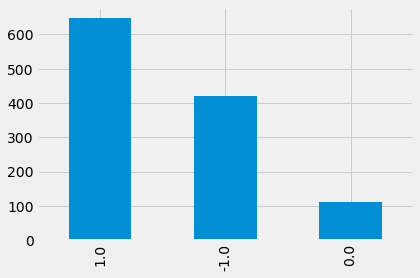

In [46]:
data.polarity.value_counts().plot.bar()
data.polarity.value_counts()

In [70]:
data1=data.loc[data['firm'] == 'American-Express']
polarity=[] # list which will contain the polarity of the comments
subjectivity=[] # list which will contain the subjectivity of the comments
for i in data1['pros'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)
data1['polarity'] = polarity
data1['subjectivity'] = subjectivity

data1['polarity'].mean()

<ipython-input-70-6449e18ae98c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['polarity'] = polarity
<ipython-input-70-6449e18ae98c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['subjectivity'] = subjectivity


0.2923800287877523

In [69]:
data2=data.loc[data['firm'] == 'Accenture']
polarity=[] # list which will contain the polarity of the comments
subjectivity=[] # list which will contain the subjectivity of the comments
for i in data2['pros'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)
data2['polarity'] = polarity
data2['subjectivity'] = subjectivity

data2['polarity'].mean()

<ipython-input-69-a7a9a9f0f300>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['polarity'] = polarity
<ipython-input-69-a7a9a9f0f300>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['subjectivity'] = subjectivity


0.31903834966321626

In [68]:
data3=data.loc[data['firm'] == 'Apple']
polarity=[] # list which will contain the polarity of the comments
subjectivity=[] # list which will contain the subjectivity of the comments
for i in data3['pros'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)
data3['polarity'] = polarity
data3['subjectivity'] = subjectivity

data3['polarity'].mean()

<ipython-input-68-07700b38c0b9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['polarity'] = polarity
<ipython-input-68-07700b38c0b9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['subjectivity'] = subjectivity


0.3351097029838281

In [67]:
data4=data.loc[data['firm'] == 'Barclays']
polarity=[] # list which will contain the polarity of the comments
subjectivity=[] # list which will contain the subjectivity of the comments
for i in data4['pros'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)
data4['polarity'] = polarity
data4['subjectivity'] = subjectivity

data4['polarity'].mean()

<ipython-input-67-50fca9b59828>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['polarity'] = polarity
<ipython-input-67-50fca9b59828>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['subjectivity'] = subjectivity


0.2904350340676369

In [66]:
data5=data.loc[data['firm'] == 'Citi']
polarity=[] # list which will contain the polarity of the comments
subjectivity=[] # list which will contain the subjectivity of the comments
for i in data5['pros'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)
data5['polarity'] = polarity
data5['subjectivity'] = subjectivity

data5['polarity'].mean()

<ipython-input-66-2c4ed228c1c7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data5['polarity'] = polarity
<ipython-input-66-2c4ed228c1c7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data5['subjectivity'] = subjectivity


0.26099175280501813

In [65]:
data6=data.loc[data['firm'] == 'EY']
polarity=[] # list which will contain the polarity of the comments
subjectivity=[] # list which will contain the subjectivity of the comments
for i in data6['pros'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)
data6['polarity'] = polarity
data6['subjectivity'] = subjectivity

data6['polarity'].mean()

<ipython-input-65-b09afa36cf84>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data6['polarity'] = polarity
<ipython-input-65-b09afa36cf84>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data6['subjectivity'] = subjectivity


0.23557635548859251

In [64]:
data7=data.loc[data['firm'] == 'Goldman-Sachs']
polarity=[] # list which will contain the polarity of the comments
subjectivity=[] # list which will contain the subjectivity of the comments
for i in data7['pros'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)
data7['polarity'] = polarity
data7['subjectivity'] = subjectivity

data7['polarity'].mean()

<ipython-input-64-ca073d120d96>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data7['polarity'] = polarity
<ipython-input-64-ca073d120d96>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data7['subjectivity'] = subjectivity


0.3099229124356439

In [80]:
Companies = [['American-Express', 0.2923], ['Accenture', 0.3190], ['Apple', 0.3351],['Barclays', 0.2904],['Citi', 0.2609],['EY', 0.2355],['Goldman-Sachs', 0.3099]]
C = pd.DataFrame(Companies, columns=['Company', 'Sentiment'])
C

,Company,Sentiment
0,American-Express,0.2923
1,Accenture,0.3190
2,Apple,0.3351
3,Barclays,0.2904
4,Citi,0.2609
5,EY,0.2355
6,Goldman-Sachs,0.3099


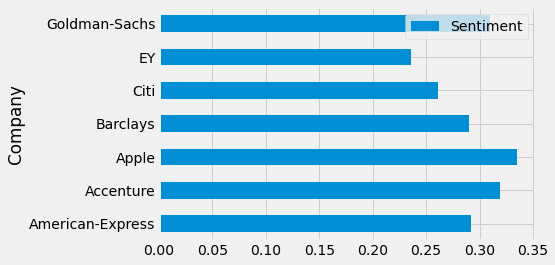

In [85]:
ax = C.plot.barh(x='Company', y='Sentiment', rot=0)